In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
# from torchvision import datasets
from torch.utils.data import DataLoader
# from torchvision import transforms
from torchvision.io import read_image
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

import os

In [2]:
# https://www.kaggle.com/code/chamaljayasinghe123/face-expression-recognition/edit

# Generate CVS file that store images' directory and their labels

In [2]:
encode_labels = {
    'angry': 0,
    "disgust": 1,
    'fear': 2,
    "happy": 3,
    'neutral' : 4, 
    'sad': 5,
    'surprise': 6
}

In [3]:
a = np.array(["BTC", "ETH", "AUD", "DOGE"])
endswidth = "USD"

print(np.core.defchararray.add(endswidth, a).tolist())

['USDBTC', 'USDETH', 'USDAUD', 'USDDOGE']


In [4]:
def createCSVfile(input_directory, output_directory, file_name):
    # input_directory: train/test's package
    dir_list = os.listdir(input_directory)

    data = {
        "image": [],
        "label": []
    }

    for dir in dir_list:
        currentPath = os.path.join(input_directory, dir)
        images = os.listdir(currentPath)
        labels = [encode_labels[dir]] * len(images)

        data['image'] += np.core.defchararray.add(currentPath + "/", np.array(images)).tolist()
        data['label'] += labels

    df = pd.DataFrame.from_dict(data)

    out_dir = output_directory + file_name
    if not os.path.exists(output_directory):
        os.mkdir(out_dir)
        if os.path.exists(out_dir):
            os.remove(out_dir)
    df.to_csv(out_dir, index=False)

# Create Dataset

In [5]:
class FaceExpressionDataset(Dataset):
    def __init__(self, csv_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    def get_labels(self):
        return self.img_labels['label']
        

In [6]:
createCSVfile('images/train/', './', 'train.csv')
createCSVfile('images/validation/', './', 'validation.csv')

## Plot dataset

In [7]:
def barchartOutput(csv_file):
    data = pd.read_csv(csv_file)
    y = data.label
    
    output = {
      i: len(y[y == i]) for i in range(7)
    }
    plt.bar(output.keys(), output.values())

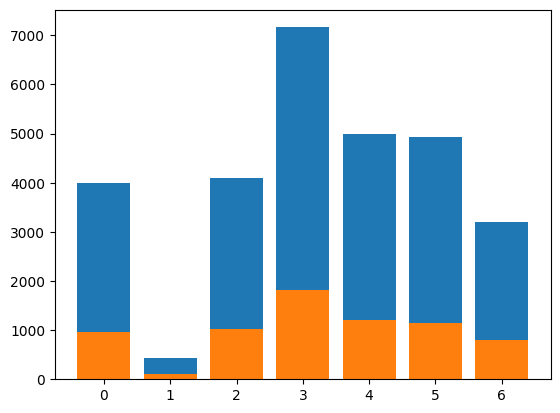

In [8]:
barchartOutput('./train.csv')
barchartOutput('./validation.csv')

# Read Dataset

In [10]:
# !pip install torchsampler

In [9]:
from torchsampler import ImbalancedDatasetSampler

In [10]:
training_set = FaceExpressionDataset(csv_file='./train.csv')
test_set = FaceExpressionDataset(csv_file='./validation.csv')

In [11]:
train_dataloader = DataLoader(training_set, batch_size=128, num_workers=2, shuffle=False, sampler=ImbalancedDatasetSampler(training_set))
test_dataloader = DataLoader(test_set, batch_size=128, num_workers=2, shuffle=False)

In [ ]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
labels_map = {v: k for k, v in encode_labels.items()}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Train with Neural Network

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(48*48, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
    
        # Compute prediction error
        pred = model(X.float() / 255)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    f1_score = 0
    
    y_pred, y_true = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float() / 255)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            y_pred.extend(pred.argmax(1).cpu().numpy())
            y_true.extend(y.cpu().numpy())
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(classification_report(y_true, y_pred))

In [21]:
# model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test))

In [ ]:
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    # Training phase
    train(train_dataloader, model, loss_fn, optimizer)

    # Evaluation phase
    test_loss, accuracy = test(test_dataloader, model, loss_fn)

    # Print or store the evaluation metrics
    print(f"\nEvaluation - Epoch {epoch + 1}:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

print("Training and Evaluation Done!")


# Train with Resnet

In [ ]:
from torchvision.models import resnet18, resnet34, resnet50

model = resnet50(num_classes = 7)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

model = model.to(device)

In [ ]:
model

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# Train with CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.relu2(x)
        x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")